In [46]:
# ============================
# IMPORT LIBRARY - STUDI KASUS
# ============================
import simpy
import random
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
import os

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


In [47]:
# ============================
# KONFIGURASI SIMULASI PIKET
# ============================
@dataclass
class ConfigPiket:
    """Konfigurasi parameter simulasi piket kantin"""
    
    # Parameter dasar
    NUM_PETUGAS: int = 7           # Total petugas piket
    NUM_MEJA: int = 60             # Jumlah meja
    MAHASISWA_PER_MEJA: int = 3    # Mahasiswa per meja
    TOTAL_OMPRENG: int = 180       # Total ompreng (60 x 3)
    
    # Alokasi petugas per stage
    NUM_PETUGAS_LAUK: int = 2      # Petugas untuk stage 1 (isi lauk)
    NUM_PETUGAS_ANGKUT: int = 2    # Petugas untuk stage 2 (angkut)
    NUM_PETUGAS_NASI: int = 3      # Petugas untuk stage 3 (isi nasi)
    
    # Distribusi waktu (dalam menit)
    MIN_LAUK_TIME: float = 0.5     # 30 detik
    MAX_LAUK_TIME: float = 1.0     # 1 menit
    
    MIN_ANGKUT_TIME: float = 0.33  # 20 detik
    MAX_ANGKUT_TIME: float = 1.0   # 1 menit
    
    MIN_NASI_TIME: float = 0.5     # 30 detik
    MAX_NASI_TIME: float = 1.0     # 1 menit
    
    # Kapasitas angkut per trip
    MIN_OMPRENG_PER_TRIP: int = 4
    MAX_OMPRENG_PER_TRIP: int = 7
    
    # Waktu mulai
    START_HOUR: int = 7
    START_MINUTE: int = 0
    
    # Seed untuk reproduktibilitas
    RANDOM_SEED: int = 42

print("✅ Konfigurasi piket siap")

✅ Konfigurasi piket siap


In [48]:
# ============================
# MODEL SIMULASI PIKET KANTIN
# ============================
class PiketKantinDES:
    """Model Discrete Event Simulation untuk piket kantin IT Del"""
    
    def __init__(self, config: ConfigPiket):
        self.config = config
        self.env = simpy.Environment()
        
        # Resources: Petugas untuk 3 stage
        self.petugas_lauk = simpy.Resource(self.env, capacity=config.NUM_PETUGAS_LAUK)
        self.petugas_angkut = simpy.Resource(self.env, capacity=config.NUM_PETUGAS_ANGKUT)
        self.petugas_nasi = simpy.Resource(self.env, capacity=config.NUM_PETUGAS_NASI)
        
        # Buffer/Antrian antar stage
        self.buffer_lauk_selesai = simpy.Store(self.env)
        self.buffer_angkut_selesai = simpy.Store(self.env)
        
        # Statistik
        self.statistics = {
            'ompreng_data': [],
            'stage_times': {'lauk': [], 'angkut': [], 'nasi': []},
            'utilisasi_petugas': {'lauk': [], 'angkut': [], 'nasi': []}
        }
        
        # Waktu mulai simulasi
        self.start_time = datetime(2024, 1, 1, config.START_HOUR, config.START_MINUTE)
        
        # Set random seed
        random.seed(config.RANDOM_SEED)
        np.random.seed(config.RANDOM_SEED)
    
    def waktu_ke_jam(self, waktu_simulasi: float) -> datetime:
        """Konversi waktu simulasi (menit) ke datetime"""
        return self.start_time + timedelta(minutes=waktu_simulasi)
    
    def generate_lauk_time(self) -> float:
        """Generate waktu isi lauk (30-60 detik) dalam menit"""
        return random.uniform(self.config.MIN_LAUK_TIME, self.config.MAX_LAUK_TIME)
    
    def generate_angkut_time(self) -> float:
        """Generate waktu angkut (20-60 detik) dalam menit"""
        return random.uniform(self.config.MIN_ANGKUT_TIME, self.config.MAX_ANGKUT_TIME)
    
    def generate_nasi_time(self) -> float:
        """Generate waktu isi nasi (30-60 detik) dalam menit"""
        return random.uniform(self.config.MIN_NASI_TIME, self.config.MAX_NASI_TIME)
    
    def generate_ompreng_per_trip(self) -> int:
        """Generate jumlah ompreng per trip angkut (4-7)"""
        return random.randint(self.config.MIN_OMPRENG_PER_TRIP, self.config.MAX_OMPRENG_PER_TRIP)
    
    def proses_stage_lauk(self, ompreng_id: int):
        """Stage 1: Mengisi lauk ke ompreng"""
        waktu_mulai = self.env.now
        
        with self.petugas_lauk.request() as request:
            yield request
            
            # Catat utilisasi
            self.statistics['utilisasi_petugas']['lauk'].append({
                'time': self.env.now,
                'in_use': self.petugas_lauk.count
            })
            
            # Proses isi lauk
            lauk_time = self.generate_lauk_time()
            yield self.env.timeout(lauk_time)
        
        waktu_selesai = self.env.now
        
        # Simpan ke buffer stage berikutnya
        yield self.buffer_lauk_selesai.put({
            'ompreng_id': ompreng_id,
            'waktu_selesai_lauk': waktu_selesai,
            'waktu_lauk': lauk_time
        })
        
        self.statistics['stage_times']['lauk'].append(lauk_time)
    
    def proses_stage_angkut(self):
        """Stage 2: Mengangkat ompreng ke meja (batch processing)"""
        ompreng_batch = []
        
        while len(ompreng_batch) < self.config.TOTAL_OMPRENG:
            # Kumpulkan ompreng dari buffer lauk
            item = yield self.buffer_lauk_selesai.get()
            ompreng_batch.append(item)
            
            # Cek apakah sudah cukup untuk satu trip atau ini ompreng terakhir
            ompreng_per_trip = self.generate_ompreng_per_trip()
            sisa_ompreng = self.config.TOTAL_OMPRENG - len(ompreng_batch)
            
            if len(ompreng_batch) >= ompreng_per_trip or sisa_ompreng <= 0:
                # Proses angkut batch ini
                with self.petugas_angkut.request() as request:
                    yield request
                    
                    # Catat utilisasi
                    self.statistics['utilisasi_petugas']['angkut'].append({
                        'time': self.env.now,
                        'in_use': self.petugas_angkut.count,
                        'batch_size': len(ompreng_batch)
                    })
                    
                    # Proses angkut
                    angkut_time = self.generate_angkut_time()
                    yield self.env.timeout(angkut_time)
                
                # Kirim ke buffer stage berikutnya
                for item in ompreng_batch:
                    yield self.buffer_angkut_selesai.put({
                        'ompreng_id': item['ompreng_id'],
                        'waktu_selesai_angkut': self.env.now,
                        'waktu_angkut': angkut_time / len(ompreng_batch),  # Rata-rata per ompreng
                        'waktu_lauk': item['waktu_lauk'],
                        'waktu_selesai_lauk': item['waktu_selesai_lauk']
                    })
                
                self.statistics['stage_times']['angkut'].append(angkut_time)
                ompreng_batch = []
    
    def proses_stage_nasi(self, ompreng_id: int, data_sebelumnya: dict):
        """Stage 3: Menambahkan nasi ke ompreng"""
        waktu_mulai = self.env.now
        
        with self.petugas_nasi.request() as request:
            yield request
            
            # Catat utilisasi
            self.statistics['utilisasi_petugas']['nasi'].append({
                'time': self.env.now,
                'in_use': self.petugas_nasi.count
            })
            
            # Proses isi nasi
            nasi_time = self.generate_nasi_time()
            yield self.env.timeout(nasi_time)
        
        waktu_selesai = self.env.now
        
        # Simpan data lengkap ompreng
        self.statistics['ompreng_data'].append({
            'id': ompreng_id,
            'waktu_lauk': data_sebelumnya['waktu_lauk'],
            'waktu_angkut': data_sebelumnya['waktu_angkut'],
            'waktu_nasi': nasi_time,
            'total_waktu': data_sebelumnya['waktu_lauk'] + data_sebelumnya['waktu_angkut'] + nasi_time,
            'waktu_selesai': waktu_selesai,
            'jam_selesai': self.waktu_ke_jam(waktu_selesai)
        })
        
        self.statistics['stage_times']['nasi'].append(nasi_time)
    
    def proses_kedatangan_ompreng(self):
        """Generate proses untuk semua ompreng"""
        # Start stage 1 untuk semua ompreng
        for i in range(self.config.TOTAL_OMPRENG):
            self.env.process(self.proses_stage_lauk(i))
        
        # Start stage 2 (batch processing)
        self.env.process(self.proses_stage_angkut())
        
        # Start stage 3 untuk semua ompreng dari buffer angkut
        processed_count = 0
        while processed_count < self.config.TOTAL_OMPRENG:
            try:
                data = yield self.buffer_angkut_selesai.get()
                self.env.process(self.proses_stage_nasi(
                    data['ompreng_id'], 
                    data
                ))
                processed_count += 1
            except:
                break
    
    def run_simulation(self):
        """Jalankan simulasi"""
        self.env.process(self.proses_kedatangan_ompreng())
        self.env.run()
        return self.analyze_results()
    
    def analyze_results(self):
        """Analisis hasil simulasi"""
        if not self.statistics['ompreng_data']:
            return None, None
        
        df = pd.DataFrame(self.statistics['ompreng_data'])
        
        results = {
            'total_ompreng': len(df),
            'waktu_selesai_terakhir': df['waktu_selesai'].max(),
            'jam_selesai_terakhir': self.waktu_ke_jam(df['waktu_selesai'].max()),
            'durasi_total_menit': df['waktu_selesai'].max(),
            
            # Statistik per stage
            'avg_lauk_time': np.mean(self.statistics['stage_times']['lauk']),
            'avg_angkut_time': np.mean(self.statistics['stage_times']['angkut']),
            'avg_nasi_time': np.mean(self.statistics['stage_times']['nasi']),
            
            'total_lauk_time': sum(self.statistics['stage_times']['lauk']),
            'total_angkut_time': sum(self.statistics['stage_times']['angkut']),
            'total_nasi_time': sum(self.statistics['stage_times']['nasi']),
            
            # Utilisasi petugas
            'utilisasi_petugas': self.calculate_utilization(df),
        }
        
        return results, df
    
    def calculate_utilization(self, df):
        """Hitung utilisasi petugas per stage"""
        total_time = df['waktu_selesai'].max()
        
        utilization = {}
        
        # Utilisasi stage lauk
        if self.statistics['stage_times']['lauk']:
            total_lauk = sum(self.statistics['stage_times']['lauk'])
            utilization['lauk'] = (total_lauk / (total_time * self.config.NUM_PETUGAS_LAUK)) * 100
        
        # Utilisasi stage angkut
        if self.statistics['stage_times']['angkut']:
            total_angkut = sum(self.statistics['stage_times']['angkut'])
            utilization['angkut'] = (total_angkut / (total_time * self.config.NUM_PETUGAS_ANGKUT)) * 100
        
        # Utilisasi stage nasi
        if self.statistics['stage_times']['nasi']:
            total_nasi = sum(self.statistics['stage_times']['nasi'])
            utilization['nasi'] = (total_nasi / (total_time * self.config.NUM_PETUGAS_NASI)) * 100
        
        return utilization

print("✅ Model PiketKantinDES siap")

✅ Model PiketKantinDES siap


In [49]:
# ============================
# JALANKAN SIMULASI PIKET
# ============================
print("="*60)
print("SIMULASI PIKET KANTIN IT DEL")
print("="*60)

# Buat konfigurasi
config = ConfigPiket()

# Buat dan jalankan model
model = PiketKantinDES(config)
results, df = model.run_simulation()

# Tampilkan hasil
if results:
    print(f"\n📊 HASIL SIMULASI:")
    print(f"Total Ompreng: {results['total_ompreng']}")
    print(f"Jam Mulai: {model.start_time.strftime('%H:%M')}")
    print(f"Jam Selesai Terakhir: {results['jam_selesai_terakhir'].strftime('%H:%M')}")
    print(f"Durasi Total: {results['durasi_total_menit']:.2f} menit")
    
    print(f"\n⏱️ Waktu Rata-rata per Stage:")
    print(f"  Stage 1 (Lauk): {results['avg_lauk_time']:.2f} menit")
    print(f"  Stage 2 (Angkut): {results['avg_angkut_time']:.2f} menit")
    print(f"  Stage 3 (Nasi): {results['avg_nasi_time']:.2f} menit")
    
    print(f"\n👥 Utilisasi Petugas:")
    for stage, util in results['utilisasi_petugas'].items():
        stage_name = {'lauk': 'Stage 1 (Lauk)', 'angkut': 'Stage 2 (Angkut)', 'nasi': 'Stage 3 (Nasi)'}
        print(f"  {stage_name[stage]}: {util:.1f}%")
else:
    print("❌ Simulasi gagal!")

SIMULASI PIKET KANTIN IT DEL

📊 HASIL SIMULASI:
Total Ompreng: 180
Jam Mulai: 07:00
Jam Selesai Terakhir: 08:08
Durasi Total: 68.75 menit

⏱️ Waktu Rata-rata per Stage:
  Stage 1 (Lauk): 0.74 menit
  Stage 2 (Angkut): 0.65 menit
  Stage 3 (Nasi): 0.77 menit

👥 Utilisasi Petugas:
  Stage 1 (Lauk): 96.5%
  Stage 2 (Angkut): 16.2%
  Stage 3 (Nasi): 67.3%


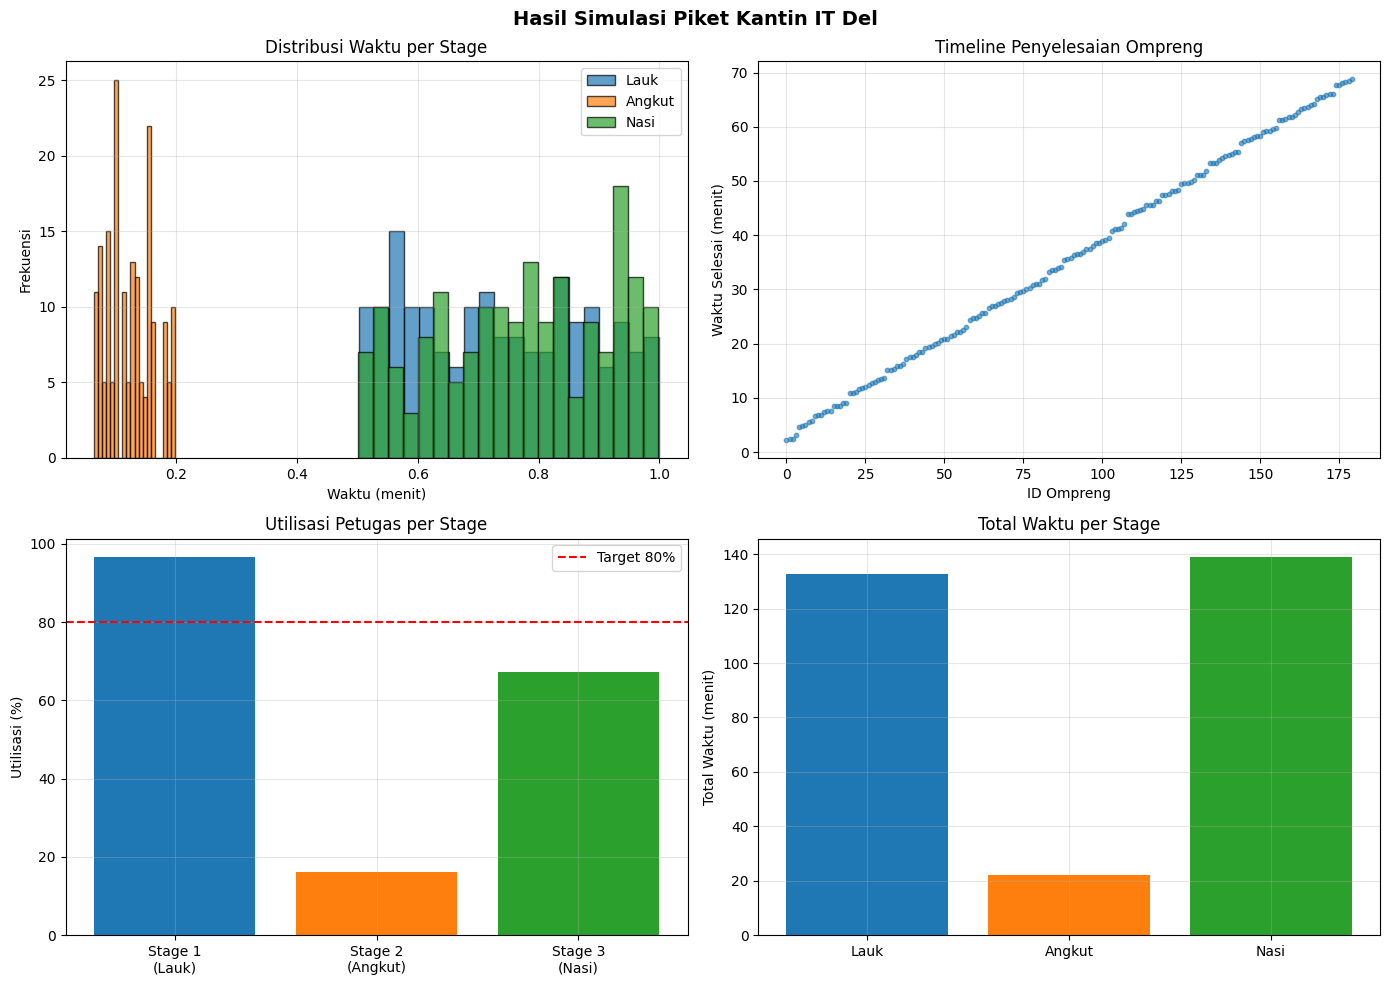


✅ Visualisasi disimpan ke artifacts/visualisasi_piket.png


In [50]:
# ============================
# VISUALISASI HASIL PIKET
# ============================

# Buat folder artifacts jika belum ada
os.makedirs('artifacts', exist_ok=True)

# Buat visualisasi
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hasil Simulasi Piket Kantin IT Del', fontsize=14, fontweight='bold')

# 1. Distribusi Waktu per Stage
axes[0, 0].hist(df['waktu_lauk'], bins=20, alpha=0.7, label='Lauk', edgecolor='black')
axes[0, 0].hist(df['waktu_angkut'], bins=20, alpha=0.7, label='Angkut', edgecolor='black')
axes[0, 0].hist(df['waktu_nasi'], bins=20, alpha=0.7, label='Nasi', edgecolor='black')
axes[0, 0].set_xlabel('Waktu (menit)')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].set_title('Distribusi Waktu per Stage')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Timeline Penyelesaian
axes[0, 1].scatter(df.index, df['waktu_selesai'], s=10, alpha=0.6)
axes[0, 1].set_xlabel('ID Ompreng')
axes[0, 1].set_ylabel('Waktu Selesai (menit)')
axes[0, 1].set_title('Timeline Penyelesaian Ompreng')
axes[0, 1].grid(True, alpha=0.3)

# 3. Utilisasi Petugas
stages = list(results['utilisasi_petugas'].keys())
utils = list(results['utilisasi_petugas'].values())
stage_names = ['Stage 1\n(Lauk)', 'Stage 2\n(Angkut)', 'Stage 3\n(Nasi)']
axes[1, 0].bar(stage_names, utils, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 0].set_ylabel('Utilisasi (%)')
axes[1, 0].set_title('Utilisasi Petugas per Stage')
axes[1, 0].axhline(y=80, color='red', linestyle='--', label='Target 80%')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Total Waktu per Stage
total_times = [results['total_lauk_time'], results['total_angkut_time'], results['total_nasi_time']]
axes[1, 1].bar(['Lauk', 'Angkut', 'Nasi'], total_times, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_ylabel('Total Waktu (menit)')
axes[1, 1].set_title('Total Waktu per Stage')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Simpan gambar
plt.savefig('artifacts/visualisasi_piket.png', dpi=300)
plt.show()

print("\n✅ Visualisasi disimpan ke artifacts/visualisasi_piket.png")